\begin{align*}
X + X + Y &{\quad \stackrel{1} \longrightarrow \quad} X + X + X \\
X + Y + Y &{\quad \stackrel{1} \longrightarrow \quad} Y + Y + Y
\end{align*}

In [1]:
%matplotlib inline

import plotting_utils as plt_utils
from crn_utils import SimulationOptions, run_simulation
import numpy as np

simulation_options = SimulationOptions()
simulation_options.set_java_path("/home/harry/.jdks/openjdk-19.0.1/bin/java")
simulation_options.set_max_time(2000)

In [2]:
# To reload for new plots
import importlib
importlib.reload(plt_utils)

<module 'plotting_utils' from '/home/harry/IdeaProjects/crn-attempt1/graphing/plotting_utils.py'>

In [3]:
simulation_options.set_repeats(500)
simulation_options.set_volumes([int(volume) for volume in np.logspace(2.0, 4.0, 10)])
simulation_options.net_from_file("./nets/tri-molecular.json")
simulation_options.use_file(True, "./csvs/tri-molecular.csv")
simulation_options.set_format("csv")

DATA = run_simulation(simulation_options)
places = DATA.columns.difference(["repeatNum", "time", "volume"])
DATA["isFinal"] = DATA.time.eq(DATA.groupby(['volume','repeatNum']).time.transform('max'))


Execution and deserialization took: 76s
Rows/second: 264053.92377260106
Memory info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20088867 entries, 0 to 20088866
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   X          int64  
 1   Y          int64  
 2   time       float64
 3   volume     int64  
 4   repeatNum  int64  
dtypes: float64(1), int64(4)
memory usage: 766.3 MB
None


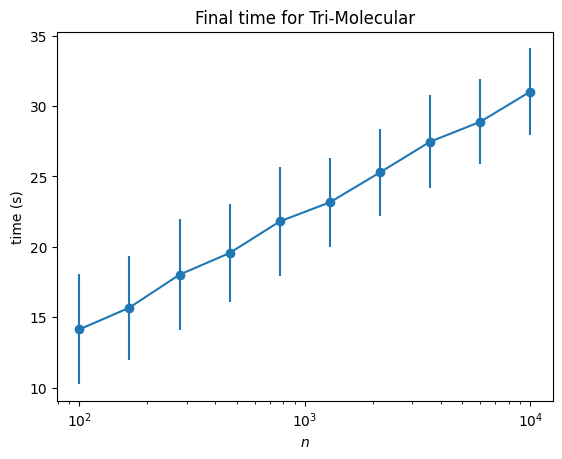

In [4]:
plt_utils.final_time_graph(DATA, "Tri-Molecular")

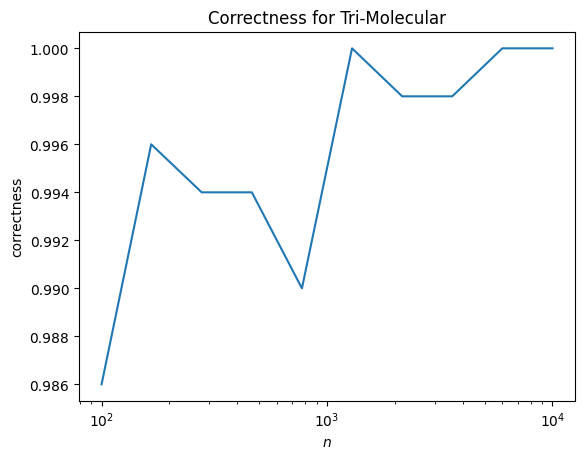

In [5]:
plt_utils.correctness_graph(DATA, "X", "Y", "Tri-Molecular")

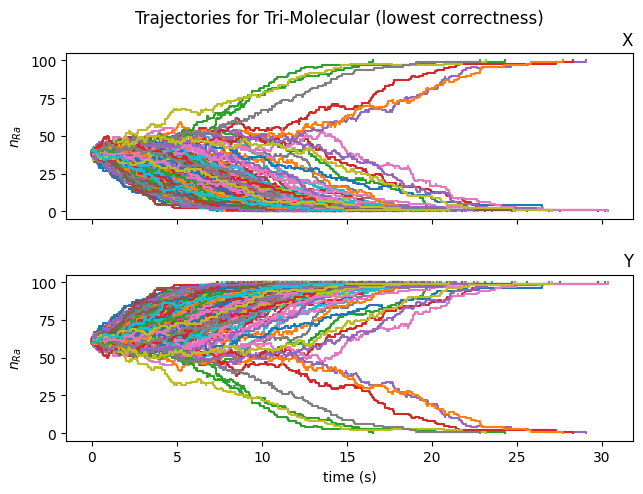

In [6]:
plt_utils.lowest_correctness_trajectory(DATA, "X", "Y", "Tri-Molecular")

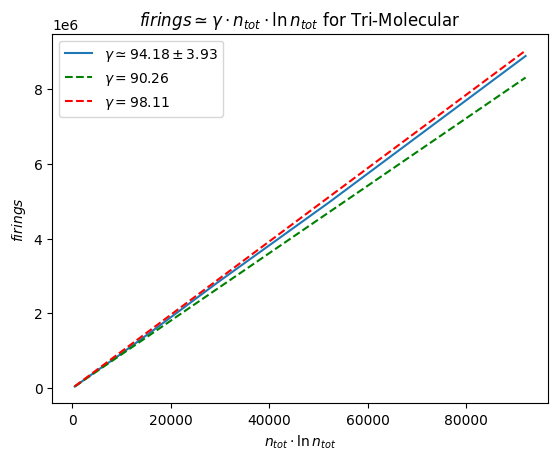

In [7]:
plt_utils.firing_gamma_graph(DATA, "Tri-Molecular")